<!-- Copyright 2023 Unai Lería Fortea

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License. -->

How to use the **compartmental** package with a more complex model:

$$
\begin{equation} \tag{4.3}
    P_{infection} = p(t)\cdot P_{infection}^{active} + (1-p(t))(1-sh(1-\phi))\cdot P_{infection}^{lockdown},
\end{equation}
$$
$$
\begin{equation*}
    P_{infection}^{j} = 1- \left(1-\lambda\frac{I}{N}\right)^{\left<k_j\right>}; \quad \textrm{with} \quad j=active, lockdown.
\end{equation*}
$$

$$
\begin{align}
    \tag{4.5} S_h[t+1]    &= S_T[t] \cdot (1-p(t))sh (1-\phi)\\
    \tag{4.6} S[t+1]      &= (S_T[t] - S_h[t]) \cdot (1- P_{infection})\\
    \tag{4.7} E[t+1]      &= (S_T[t]-S_h[t]) \cdot P_{infection} + (1-\eta)\cdot E[t]\\
    \tag{4.8} I[t+1]      &= \eta \cdot E[t]  + (1- \mu)\cdot I[t]\\
    \tag{4.9} R[t+1]      &=  \mu (1-IFR) \cdot I[t]  + R[t] \\
    \tag{4.10} P_d[t+1]    &=  \mu IFR \cdot I[t] + (1-\xi)\cdot P_d[t] \\
    \tag{4.11} D[t+1]      &= \xi\cdot P_d[t] + D[t] 
\end{align}
$$

In [1]:
import compartmental 
# compartmental.use_cupy()

import matplotlib.pyplot as plt
import numpy

First we must create the model configuration:

In [2]:
model = {
    "simulation": {
        "n_simulations": 100000,
        "n_executions": 1,
        "n_steps": 100
    },
    "compartments": {
        "Sh": { "initial_value": 0 },
        "S": { 
            "initial_value": 1,
            "minus_compartments": "I"
        },
        "E": { "initial_value": 0 },
        "I": { 
            "initial_value": "Io",
        },
        "R": { "initial_value": 0 },
        "Pd": { "initial_value": 0 },
        "D": { "initial_value": 0 },
    },
    "params": {
        "betta": {
            "min": 0.01,
            "max": 0.3,
            "min_limit": 0.01,
            "max_limit": 0.3
        },
        "Io": {
            "min": 1e-8,
            "max": 1e-5,
            "min_limit": 0,
            "max_limit": 1e-4
        },
        "phi": {
            "min": 0,
            "max": 0.5,
            "min_limit": 0,
            "max_limit": 1
        },
        "IFR": {
            "min":0.006,
            "max":0.014,
            "min_limit": 0.006,
            "max_limit": 0.014
        },
        "offset": {
            "type": "int",
            "min":5,
            "max":10,
            "min_limit": 0,
            "max_limit": 10
        }
    },
    "fixed_params": {
        "K_active": 12.4,
        "K_lockdown": 2.4,
        "sigma": 3.4,
        "mu": 1/4.2,
        "eta":1/5.2,
        "xi":1/10,
    },
    "reference": {
        "compartments" : ["D"],
        "offset": "offset" 
    },
    "results": { 
        "save_percentage": 0.5
    }
}

Now we define the evolution function, following the master differential equations shown before:

In [3]:
MyModel = compartmental.GenericModel(model)

def evolve(m, time, p_active, *args, **kargs):
    ST = m.S + m.Sh
    sh = (1 - m.I) ** (m.sigma - 1)

    P_infection_active = 1- (1- m.betta * m.I) ** m.K_active
    P_infection_lockdown = 1- (1- m.betta * m.I) ** m.K_lockdown

    P_infection = p_active[time] * P_infection_active + (1-p_active[time]) * (1-sh*(1-m.phi)) * P_infection_lockdown


    m.Sh[:]    = ST * (1-p_active[time])*sh*(1-m.phi)
    delta_S = ST * P_infection
    m.S[:]     = (ST - m.Sh)  - delta_S
   
    m.D[:]     = m.xi * m.Pd
    m.R[:]     = m.mu * (1-m.IFR)  * m.I + m.R
    m.Pd[:]    = m.mu * m.IFR  * m.I + (1-m.xi) * m.Pd
    m.I[:]     = m.eta  * m.E + (1- m.mu) * m.I
    m.E[:]     = delta_S + (1-m.eta) * m.E
    
MyModel.evolve = evolve

In [4]:
p_active = [1 if t<35 else 0.1 for t in range(model["simulation"]["n_steps"])]

Once the model is defined and the evolution function is set we can create a trajectory of the model. We can set specific values for the random parameters as follows:

In [5]:
sample, sample_params = compartmental.util.get_model_sample_trajectory(
    MyModel, p_active,
    **{"betta": 0.13,
        "Io": 1e-6,
        "phi": 0.1,
        "IFR": 0.01,
        "offset": 8}
)
# OFFSET = 8

reference = numpy.copy(sample[MyModel.compartment_name_to_index["D"]])

# This reference will be used in the comparision while compartmental is running. The correct value of the param offset is then thi OFFSET
# reference_no_offset = numpy.copy(reference)
# compartmental.util.offset_array(reference, -OFFSET)


Model running:  -> ||▮▮▮▮▮ ||100.00%  


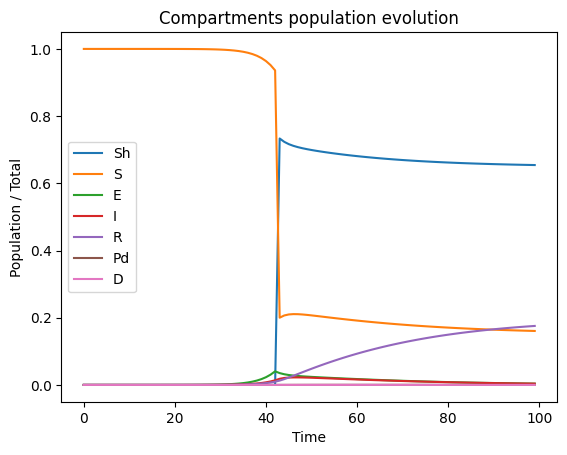

In [6]:
list_of_sample_lines = []
_range = numpy.arange(model["simulation"]["n_steps"])

for s in sample:
    list_of_sample_lines.append(_range)
    list_of_sample_lines.append(s)
    list_of_sample_lines.append('-')
    
sample_lines = plt.plot(*list_of_sample_lines)
for line, compartment in zip(sample_lines, model["compartments"]):
    line.set_label(compartment)

plt.title("Compartments population evolution")
plt.xlabel("Time")
plt.ylabel("Population / Total")
plt.legend()

We will treat this sample as data to which we will fit the model parameters. In particular, we will only use for the fitting the *recuperated* compartment (`"R"`).

We will also use the automatic adjustment of the model. Keep in mind it will only work if the initial ranges of the `params` are set close to optimal values. To see this adjustment in action we save the range `min` and `max` of each parameter to represent them later.

In [7]:
ITERS = 15
# This array is created to store min and max of params configuration in order to see the adjustment in action.
saved_params_lims = numpy.zeros((len(MyModel.configuration["params"]), 2, ITERS))

# Main loop of adjustments:
# 1. Run
# 2. Read results
# 3. Compute weights
# 4. Adjuts configuration
for i in range(ITERS):
    MyModel.run(reference, f"my_model{i}.data", p_active)
    
    results = compartmental.util.load_parameters(f"my_model{i}.data")
    
    weights = numpy.exp(-2*results[0]/numpy.min(results[0]))
    weights /= numpy.min(weights)

    compartmental.util.auto_adjust_model_params(MyModel, results, weights)
    
    # Needed to see the max and min evolution in the adjustment
    for p, v in MyModel.configuration["params"].items():
        saved_params_lims[MyModel.param_to_index[p], 0, i] = v["min"]
        saved_params_lims[MyModel.param_to_index[p], 1, i] = v["max"]

Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  
Model running:  -> ||▮▮▮▮▮ ||100.00%  


Now we can plot how the parameters limits have been modified in those iterations.

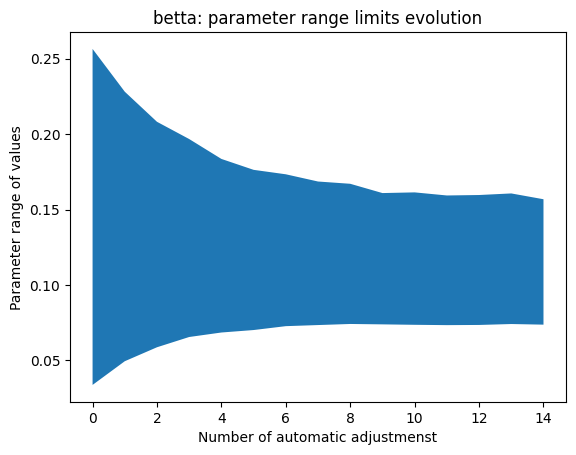

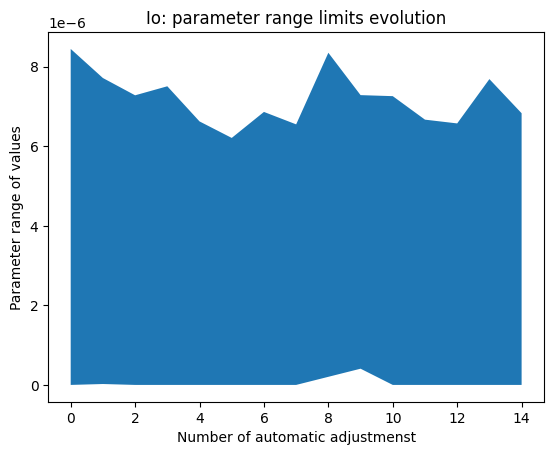

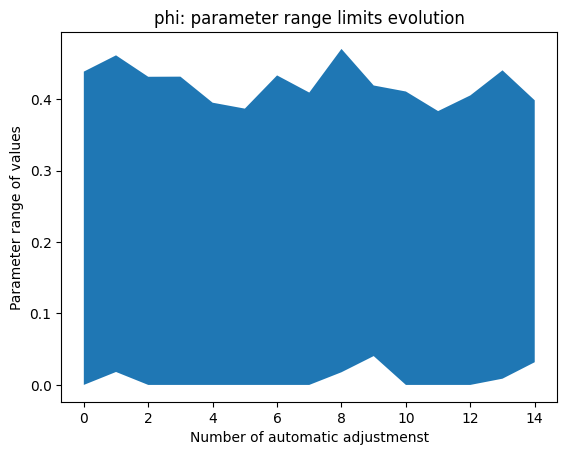

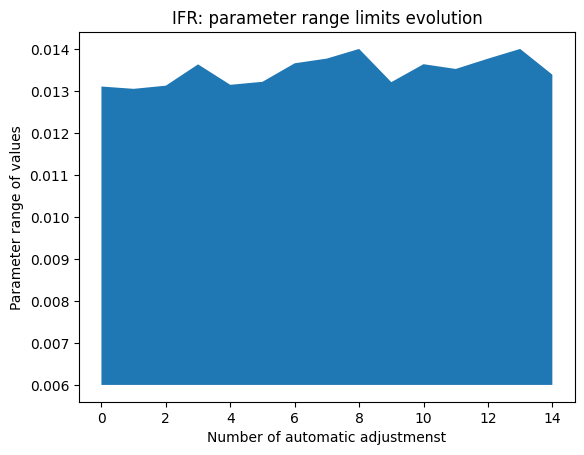

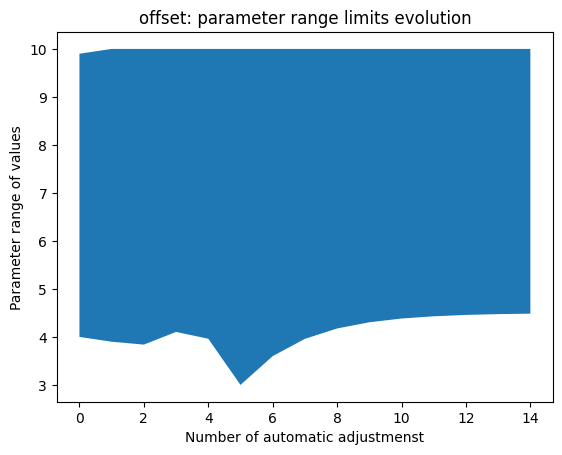

In [8]:
# Plot evolution of the parameters adjustment
for i, (k,v) in enumerate(MyModel.configuration["params"].items()):
    plt.figure()
    plt.title(f"{k}: parameter range limits evolution")
    plt.ylabel("Parameter range of values")
    plt.xlabel("Number of automatic adjustmenst")
    plt.fill_between(range(ITERS), saved_params_lims[i, 0, :], saved_params_lims[i, 1, :])

Now we should be close to the optimal configuration. We should make a big simulation to obtain good results:

In [9]:
# Update for final photo with more samples
MyModel.configuration.update({
    "simulation": {
        "n_simulations": 200000,
        "n_executions": 4,
        "n_steps": 100
    },
    "results": {
        "save_percentage": 0.01
    }
})

MyModel.run(reference, "my_model.data", p_active)

Model running:  -> ||▮▮▮▮▮ ||100.00%  


Once the results are written in the `sir.data` file we can load them and plot some results. For example the reference with a shadow of the results or histograms with infered likelihood of the parameters

In [13]:
results = compartmental.util.load_parameters("my_model.data")
weights = numpy.exp(-2*results[0]/numpy.min(results[0]))
weights /= numpy.min(weights)

percentiles = compartmental.util.get_percentiles_from_results(MyModel, results, 30, 70, weights, p_active, weights)
try:
    # In case cupy is used
    percentiles = percentiles.get()
    sample = sample.get()
    weights = weights.get()
    results = results.get()
    sample_params = sample_params.get()
except AttributeError:
    pass

# Plot sample with a shadow of the results.
plt.figure()
plt.fill_between(numpy.arange(percentiles.shape[2]), percentiles[0,0], percentiles[0,2], alpha=0.3)
plt.xlabel("Simulation time")
plt.ylabel("Daily Deaths / Total population")
plt.plot(reference, 'black')
plt.plot(numpy.arange(percentiles.shape[2]), percentiles[0,1], '--', color='purple')
tax = plt.twinx()
tax.plot(p_active, ':', color='green')
tax.set_ylabel(r"$p(t)$")

# Histograms with infered likelihood of the parameters
fig, *axes = plt.subplots(1, len(results)-1)
fig.set_figheight(3.5)
fig.set_figwidth(16)
for i, ax in enumerate(axes[0], 1):
    _5, _50, _95 = compartmental.util.weighted_quantile(results[i], [5, 50, 95], weights)
    for k, index in MyModel.param_to_index.items():
        if index == i-1:
            ax.set_title(k)
    ax.hist(results[i], weights=weights)
    
    ax.vlines(_5, *ax.get_ylim(), 'green')
    ax.vlines(_50, *ax.get_ylim(), 'black')
    ax.vlines(_95, *ax.get_ylim(), 'purple')

    ax.vlines(sample_params[i-1], ax.get_ylim()[0], ax.get_ylim()[1]*3/4, 'red')
    

plt.show()

Model running:  -> ||▮▮▮▮▮ ||100.00%  


As you can see, we are close. The red line shows the reference value, and the black one the median.

Now we can use a manual trajectory visualizer. Keep in mind that in the trajectory selector the selected value is the red line.

In [11]:
%matplotlib
plt.ion()

values = compartmental.util.get_trajecty_selector(
    MyModel, results, weights, reference, p_active, show_only_reference=True
)
print(values)
plt.ioff()
